# Лабораторная работа 3: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [597]:
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import cvxopt as cvx
from sklearn.datasets import make_classification, make_moons, make_circles

In [598]:
P = matrix(np.array([[2.0, 0.0],
                     [0.0, 8.0]]))

q = matrix(np.array([-8.0, -16.0]))

G = matrix(np.array([[1.0, 1.0], 
                     [-1.0, 0.0], 
                     [1.0, 0.0], 
                     [0.0, -1.0]]))

h = matrix(np.array([5.0, 0.0, 3.0, 0.0]))

sol = solvers.qp(P, q, G, h)

In [599]:
print(sol["x"])

[ 3.00e+00]
[ 2.00e+00]



### Попробуем повыбрасывать различные неравенства и получим следущее:

In [600]:
G = matrix(np.array([[1.0, 0.0]]))

h = matrix(np.array([3.0]))

sol = solvers.qp(P, q, G, h)

In [601]:
print(sol["x"])

[ 3.00e+00]
[ 2.00e+00]



### Из этого можем сделать вывод, что 
$$ \quad \text{не являются активными неравенствами:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1,  
x_2 \geq 0$$
$$ \quad \text{является активным неравенством, т.е. влияет на точку оптимума:} \; x_1 \leq 3$$

## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

### 1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.

In [618]:
def square_transform(X):
    X_new = X.copy()
    X_new[1] = X_new[0] ** 2 + X_new[1] ** 2
    return X_new


class LinearSVM:
    def __init__(self, X, y, C):
        self.X = X
        self.y = y
        self.C = C
        self.w = 0
        self.bias = 0
        
    def compute_cvx_matrices(self):
        X = self.X 
        y = self.y
        C = self.C
        
        N = X.shape[1]
        
        P = np.dot((X * y).T, (X * y))
        q = -np.ones((N))
        G = np.vstack((-(np.eye(N)), (np.eye(N))))
        h = np.hstack((np.zeros(N), np.ones(N) * C))
        A = y
        b = 0.0
        
        P = cvx.matrix(P)
        q = cvx.matrix(q)
        G = cvx.matrix(G)
        h = cvx.matrix(h)
        A = cvx.matrix(A, tc='d')
        b = cvx.matrix(b)
        return P, q, G, h, A, b
    
    def fit(self):
        solvers.options['show_progress'] = False
        
        X = self.X 
        y = self.y
        C = self.C
        
        P, q, G, h, A, b = self.compute_cvx_matrices()
        
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol["x"])
        
        S = (alphas > 10 ** -5).reshape(-1)
        
        sv_X = X.T[S].T
        
        w = np.dot(sv_X, (alphas[S] * y.T[S]))
        
        bias = np.mean(y.T[S] - np.dot(np.dot(sv_X.T, sv_X), (alphas[S] * y.T[S])))
        
        self.S = S
        self.w = w
        self.bias = bias
        self.sv_X = sv_X
        
        
    def plot_graph(self, graph):
        X = self.X
        y = self.y
        w = self.w
        b = self.bias
        
        
        X1 = X[0]
        X2 = X[1]
        
        
        x1 = np.linspace(X1.min(), X1.max(), 15)
        
        x2_dividing_line = - self.bias / (w[1]) - (w[0] / w[1]) * x1
        
        x2_border_top = (-1 - b) / w[1] - (w[0] / w[1]) * x1
        
        x2_border_bottom = (1 - b) / w[1] - (w[0] / w[1]) * x1
        
        
        graph.plot(x1, x2_dividing_line, c="darkorange")
        graph.plot(x1, x2_border_top, "--", c="salmon")
        graph.plot(x1, x2_border_bottom, "--", c="salmon")
        

        
        X_plus_index = ((y == 1).reshape(-1))
        X_minus_index = ((y == -1).reshape(-1))
        
        sv_plus_index = (self.S * (y == 1).reshape(-1))
        sv_minus_index = (self.S * (y == -1).reshape(-1))
        
        
        graph.scatter(X1[X_plus_index], X2[X_plus_index], c="darkcyan")
        graph.scatter(X1[X_minus_index], X2[X_minus_index], c="hotpink")
        graph.scatter(X1[sv_plus_index], X2[sv_plus_index], c="aqua")
        graph.scatter(X1[sv_minus_index], X2[sv_minus_index], c="pink")
        
        graph.set_title(f"C = {self.C}. Опорных векторов - {sum(self.S)}")
        graph.set_xlabel("X1")
        graph.set_ylabel("X2")
        
    def predict_proba(self, X):
        return (dot(self.w.T, X) + self.bias).flatten()
    
    def predict(self, X):
        return np.sign(self.predict_proba(X))

### 2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:

#### - с линейно-разделимыми классами

Text(0, 0.5, 'X2')

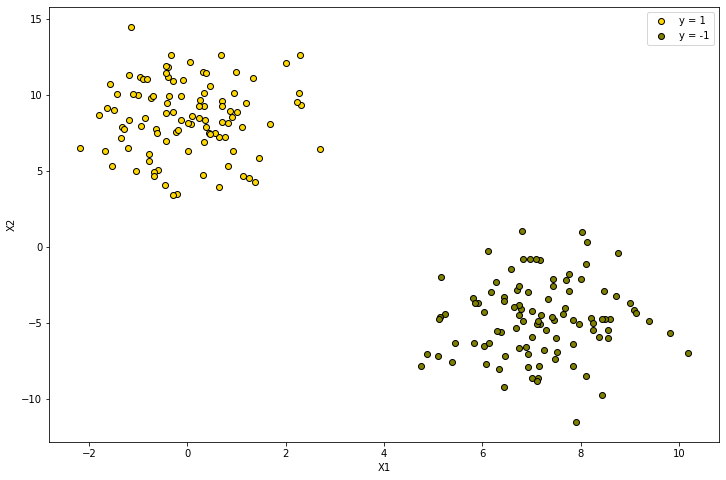

In [619]:
plt.figure(figsize=(12,8))
size = 100

mean0 = [0, 9]
cov0 = [[1, 0], [0, 5]] 
data0 = np.random.multivariate_normal(mean0, cov0, size)

mean1 = [7, -5]
cov1 = [[1, 0], [0, 5]]
data1 = np.random.multivariate_normal(mean1, cov1, size)

X_lin_sep = np.vstack((data0, data1)).T

y_lin_sep = np.hstack(((np.ones(size)), (-np.ones(size)))).reshape(1, -1)

plt.scatter(data0[:, 0], data0[:, 1], c='gold', edgecolor='k')
plt.scatter(data1[:, 0], data1[:, 1], c='olive', edgecolor='k')
plt.legend(['y = 1', 'y = -1'])
plt.xlabel("X1")
plt.ylabel("X2")

#### - с хорошо разделимыми классами, но не линейно

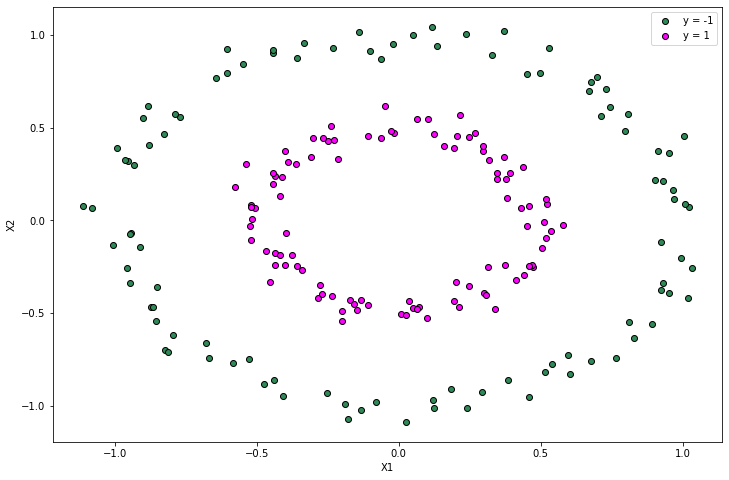

In [620]:
plt.figure(figsize=(12,8))

size = 100

X, y = make_circles(n_samples=size * 2,  factor=0.5, noise=0.05, shuffle=False)
y[:100] = -1

plt.scatter(X[:size, 0], X[:size, 1], c='seagreen', cmap='autumn', edgecolor='black')
plt.scatter(X[size:, 0], X[size:, 1], c='magenta', cmap='autumn', edgecolor='black')

plt.legend(['y = -1', 'y = 1'])
plt.xlabel("X1")
plt.ylabel("X2")

X_not_lin_sep = X.T
y_not_lin_sep = y.reshape(1, -1)

#### - с плохо разделимыми классами по имеющимся признакам

Text(0, 0.5, 'X2')

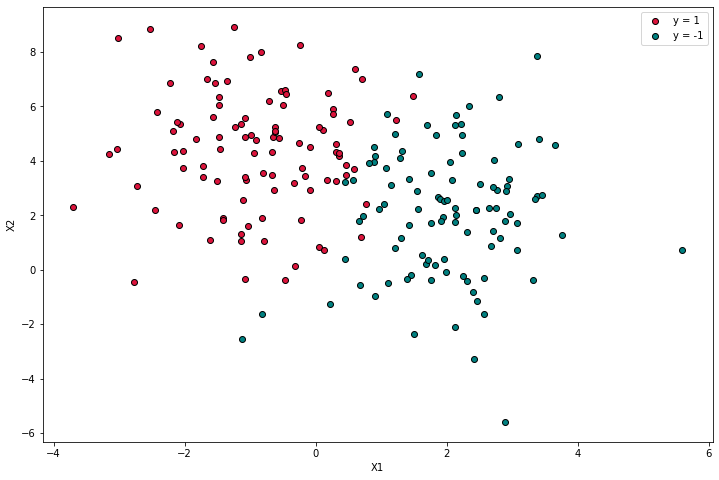

In [657]:
plt.figure(figsize=(12,8))
size = 100

mean0 = [-1, 4]
cov0 = [[1, 0], [0, 5]] 
data0 = np.random.multivariate_normal(mean0, cov0, size)

mean1 = [2, 2]
cov1 = [[1, 0], [0, 5]]
data1 = np.random.multivariate_normal(mean1, cov1, size)

X_poor_sep = np.vstack((data0, data1)).T

y_poor_sep = np.hstack(((np.ones(size)), (-np.ones(size)))).reshape(1, -1)

plt.scatter(data0[:, 0], data0[:, 1], c='crimson', edgecolor='k')
plt.scatter(data1[:, 0], data1[:, 1], c='teal', edgecolor='k')
plt.legend(['y = 1', 'y = -1'])
plt.xlabel("X1")
plt.ylabel("X2")

### 3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.

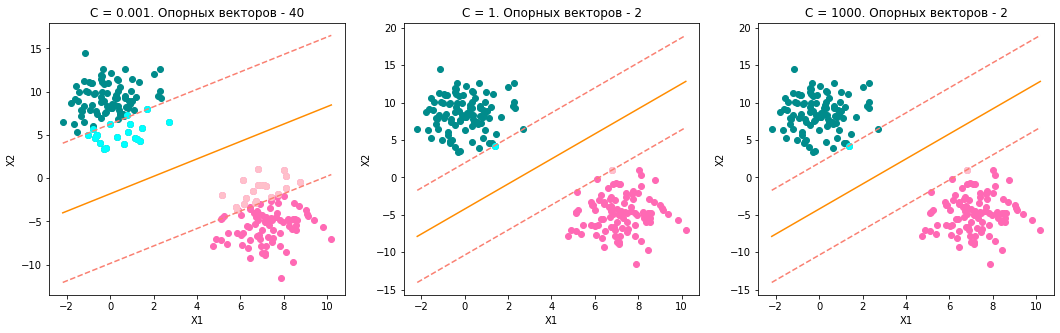

In [646]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

X = X_lin_sep
y = y_lin_sep

C_array = [0.001, 1, 1000]

for i in range(3):
    C = C_array[i]
    svm = LinearSVM(X, y, C)
    svm.fit()
    svm.plot_graph(ax[i])

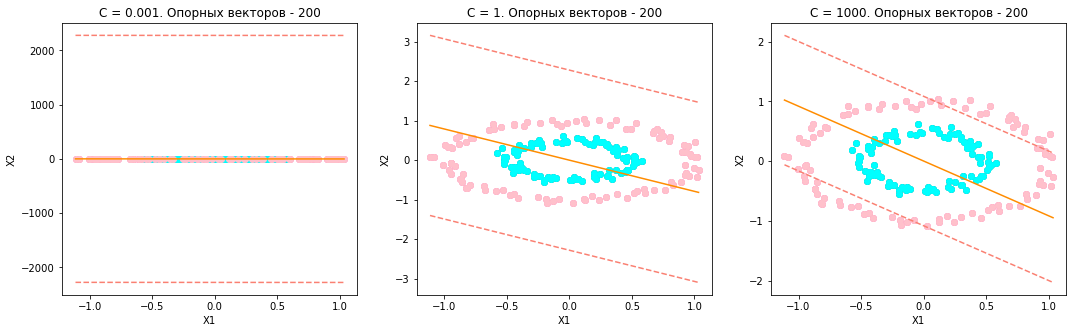

In [647]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

X = X_not_lin_sep
y = y_not_lin_sep

C_array = [0.001, 1, 1000]
for i in range(3):
    C = C_array[i]
    svm = LinearSVM(X, y, C)
    svm.fit()
    svm.plot_graph(ax[i])

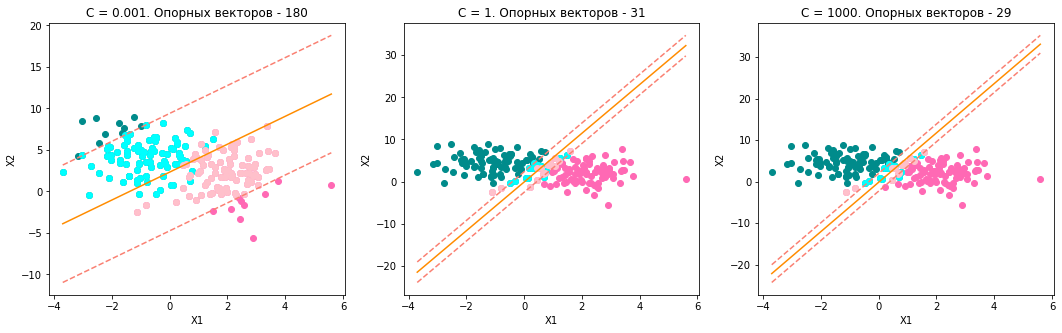

In [658]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

X = X_poor_sep
y = y_poor_sep

C_array = [0.001, 1, 1000]

for i in range(3):
    C = C_array[i]
    svm = LinearSVM(X, y, C)
    svm.fit()
    svm.plot_graph(ax[i])

### 4. Как зависит число опорных векторов от параметра $C$ для различных выборок?

#### Число опорных векторов уменьшается при увеличении параметра С.

### 5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

Text(0, 0.5, 'X1 ** 2 + X2 ** 2')

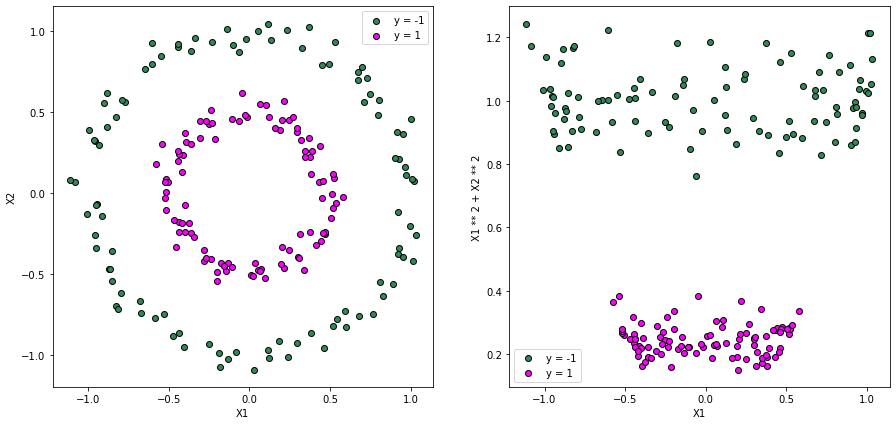

In [649]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

X = X_not_lin_sep
y = y_not_lin_sep

ax[0].scatter(X[0][:100], X[1][:100], c='seagreen', cmap='autumn', edgecolor='black')
ax[0].scatter(X[0][100:], X[1][100:], c='magenta', cmap='autumn', edgecolor='black')

ax[0].legend(['y = -1', 'y = 1'])
ax[0].set_xlabel("X1")
ax[0].set_ylabel("X2")


X_new = square_transform(X)

ax[1].scatter(X_new[0][:100], X_new[1][:100], c='seagreen', cmap='autumn', edgecolor='black')
ax[1].scatter(X_new[0][100:], X_new[1][100:], c='magenta', cmap='autumn', edgecolor='black')

ax[1].legend(['y = -1', 'y = 1'])
ax[1].set_xlabel("X1")
ax[1].set_ylabel("X1 ** 2 + X2 ** 2")

Text(0, 0.5, 'X2')

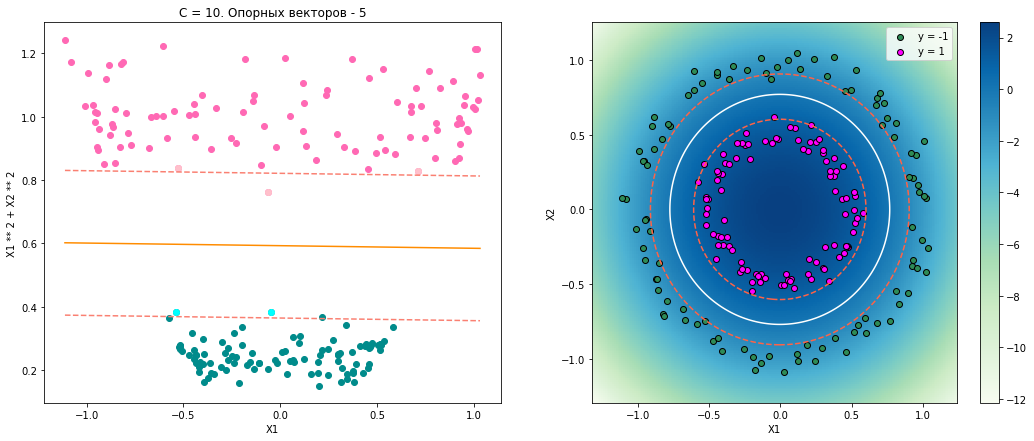

In [650]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

svm = LinearSVM(X_new, y, C=10)
svm.fit()
svm.plot_graph(ax[0])
ax[0].set_ylabel("X1 ** 2 + X2 ** 2")


xvals = linspace(X[0].min() - 0.2, X[0].max() + 0.2, 200)
yvals = linspace(X[1].min() - 0.2, X[1].max() + 0.2, 200)

xx, yy = np.meshgrid(xvals, yvals)
xx_yy = np.array([xx.ravel(), yy.ravel()])
xx_yy = square_transform(xx_yy)

zz = np.reshape(svm.predict_proba(xx_yy), xx.shape)

local = pcolormesh(xx, yy, zz, cmap='GnBu', zorder=0)
fig.colorbar(local)


levels = [-1.0, 0.0, 1.0]
colors = ['tomato', 'white', 'tomato']
linestyles =['dashed', 'solid', 'dashed']

contour(xx, yy, zz, levels=levels, colors=colors , linestyles=linestyles, linewidths=1.5)

ax[1].scatter(X[0][:100], X[1][:100], c='seagreen', cmap='autumn', edgecolor='black')
ax[1].scatter(X[0][100:], X[1][100:], c='magenta', cmap='autumn', edgecolor='black')

ax[1].legend(['y = -1', 'y = 1'])
ax[1].set_xlabel("X1")
ax[1].set_ylabel("X2")

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

### 1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.

In [651]:
class KernelSVM:
    def __init__(self, X, y, C, kernel_type, p=0, sigma=0):
        self.X = X
        self.y = y
        self.C = C
        self.p = p
        self.sigma = sigma
        self.kernel_type = kernel_type
        self.w = 0
        self.bias = 0
    
    def kernel(self, X1, X2):
        if self.kernel_type == "Linear":
            return np.dot(X1.T, X2)
        
        if self.kernel_type == "Polynomial":
            return (np.dot(X1.T, X2) + 1) ** self.p
        
        if self.kernel_type == "RBF":
            normX1 = np.linalg.norm(X1, axis=0) ** 2 
            normX2 = np.linalg.norm(X2, axis=0) ** 2
            
            degree = -(1 / (self.sigma ** 2 * 2)) * ((-2 * np.dot(X1.T, X2) + normX2).T + normX1).T
            return np.exp(degree)
    
    
    def compute_cvx_matrices(self):
        X = self.X 
        y = self.y
        C = self.C
        
        N = X.shape[1]
        
        P = self.kernel(X * y, X * y)
        q = -np.ones((N))
        G = np.vstack((-(np.eye(N)), (np.eye(N))))
        h = np.hstack((np.zeros(N), np.ones(N) * C))
        A = y
        b = 0.0
        
        P = cvx.matrix(P)
        q = cvx.matrix(q)
        G = cvx.matrix(G)
        h = cvx.matrix(h)
        A = cvx.matrix(A, tc='d')
        b = cvx.matrix(b)
        return P, q, G, h, A, b
    
    def fit(self):
        solvers.options['show_progress'] = False
        
        X = self.X 
        y = self.y
        C = self.C
        
        P, q, G, h, A, b = self.compute_cvx_matrices()
        
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol["x"])
        
        S = (alphas > 10 ** -5).reshape(-1)
        
        sv_X = X.T[S].T
        
        w = np.dot(sv_X, (alphas[S] * y.T[S]))
        
        bias = np.mean(y.T[S] - np.dot(self.kernel(sv_X, sv_X), (alphas[S] * y.T[S])))
        
        self.S = S
        self.w = w
        self.bias = bias
        self.sv_X = sv_X
        self.alphas = alphas
        
        
    def plot_graph(self, graph, fig):
        fig.tight_layout(h_pad=2)
        X = self.X
        y = self.y
        sv_X = self.sv_X
        

        xvals = linspace(X[0].min() - 0.2, X[0].max() + 0.2, 200)
        yvals = linspace(X[1].min() - 0.2, X[1].max() + 0.2, 200)

        xx, yy = np.meshgrid(xvals, yvals)
        
        xx_yy = np.array([xx.ravel(), yy.ravel()])

        zz = np.reshape(svm.predict_proba(xx_yy), xx.shape)

        local = graph.pcolormesh(xx, yy, zz, cmap='GnBu', zorder=0)
        
        colorbar(local, ax=graph)
        
        levels = [-1.0, 0.0, 1.0]
        colors = ['tomato', 'white', 'tomato']
        linestyles =['dashed', 'solid', 'dashed']

        graph.contour(xx, yy, zz, levels=levels, colors=colors , linestyles=linestyles, linewidths=2.0)
        
        X_plus_index = ((y == 1).reshape(-1))
        X_minus_index = ((y == -1).reshape(-1))
        
        sv_plus_index = (self.S * (y == 1).reshape(-1))
        sv_minus_index = (self.S * (y == -1).reshape(-1))
        
        X1 = X[0]
        X2 = X[1]
        
        graph.scatter(X1[X_plus_index], X2[X_plus_index], c="darkcyan")
        graph.scatter(X1[X_minus_index], X2[X_minus_index], c="hotpink")
        graph.scatter(X1[sv_plus_index], X2[sv_plus_index], c="aqua")
        graph.scatter(X1[sv_minus_index], X2[sv_minus_index], c="pink")
        
        if self.kernel_type == "Linear":
            title = f"C = {self.C}. Kernel = {self.kernel_type}. \n"
            title += f"Кол-во опорных векторов = {sum(self.S)}"
            graph.set_title(title)
            
        if self.kernel_type == "Polynomial":
            title = f"C = {self.C}. Kernel = {self.kernel_type}. \n"
            title += f"P = {self.p}. Кол-во опорных векторов = {sum(self.S)}"
            graph.set_title(title)
        
        if self.kernel_type == "RBF":
            title = f"C = {self.C}. Kernel = {self.kernel_type}. \n"
            title += f"Sigma = {self.sigma}. Кол-во опорных векторов = {sum(self.S)}"
            graph.set_title(title)
        
        graph.set_xlabel("X1")
        graph.set_ylabel("X2")
        
    def predict_proba(self, X):
        return (np.dot(self.kernel(self.sv_X, X).T, self.alphas[self.S] * self.y.T[self.S]) + self.bias).flatten()
    
    def predict(self, X):
        return np.sign(self.predict_proba(X))

### 2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
   #### - линейная: $k(x, x') = x^Tx'$
   #### - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
   #### - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$

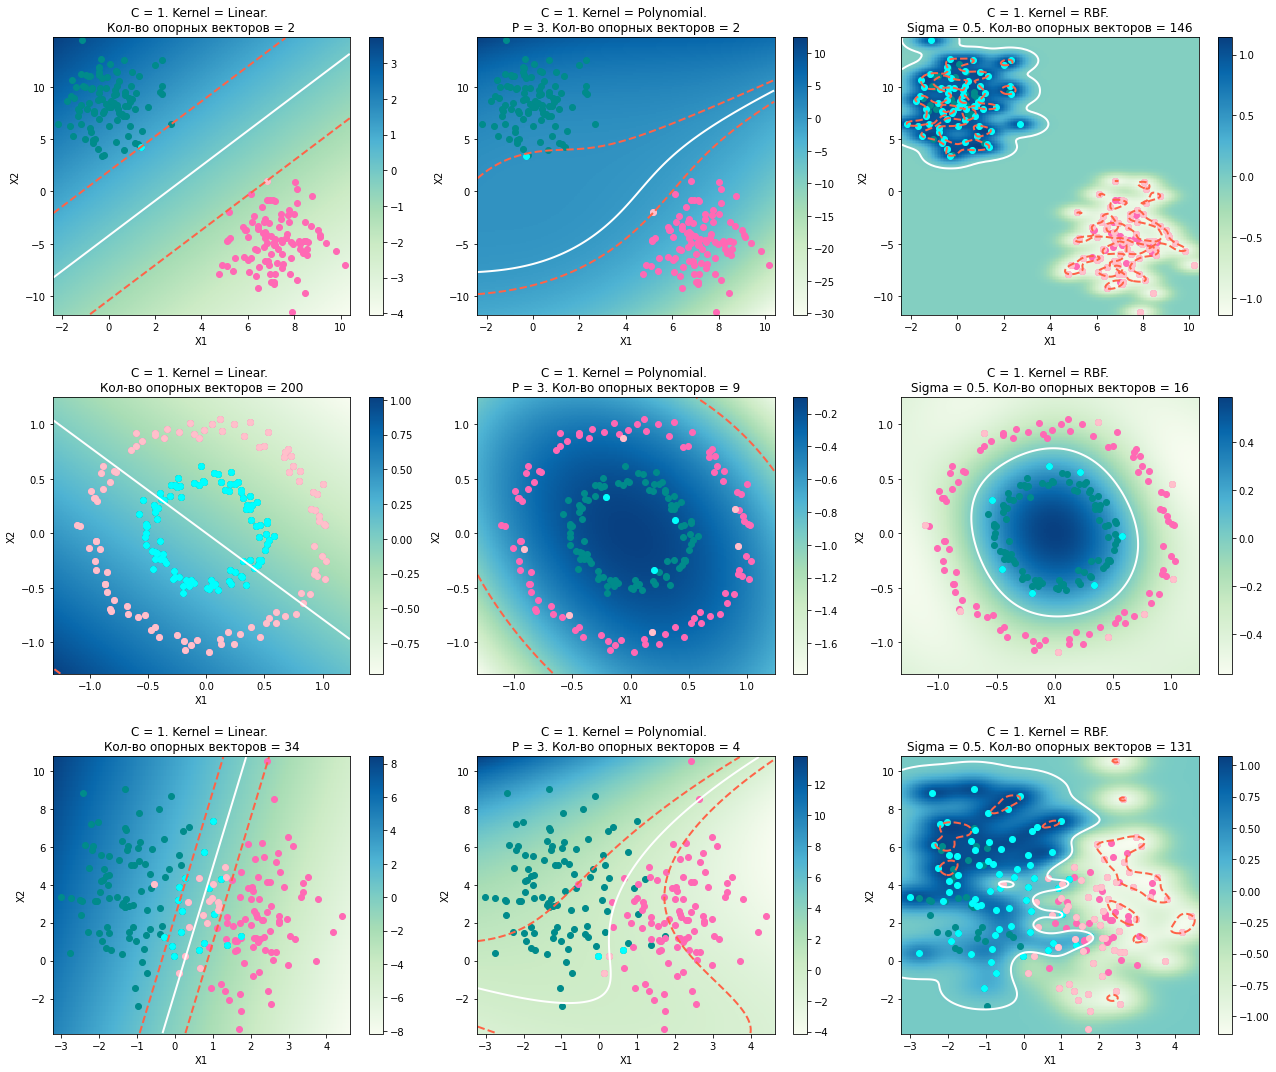

In [653]:
fig, ax = plt.subplots(3, 3, figsize=(18, 15))

kernel_type_array = ["Linear", "Polynomial", "RBF"]
C = 1
p = 3
sigma = 0.5


for i in range(3):
    X = X_lin_sep
    y = y_lin_sep
    
    svm = KernelSVM(X, y, C, kernel_type=kernel_type_array[i], p=p, sigma=sigma)
    svm.fit()
    svm.plot_graph(ax[0][i], fig)
    
    
    X = X_not_lin_sep
    y = y_not_lin_sep
    
    svm = KernelSVM(X, y, C, kernel_type=kernel_type_array[i], p=p, sigma=sigma)
    svm.fit()
    svm.plot_graph(ax[1][i], fig)
    
    
    X = X_poor_sep
    y = y_poor_sep
    
    svm = KernelSVM(X, y, C, kernel_type=kernel_type_array[i], p=p, sigma=sigma)
    svm.fit()
    svm.plot_graph(ax[2][i], fig)

### 3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?

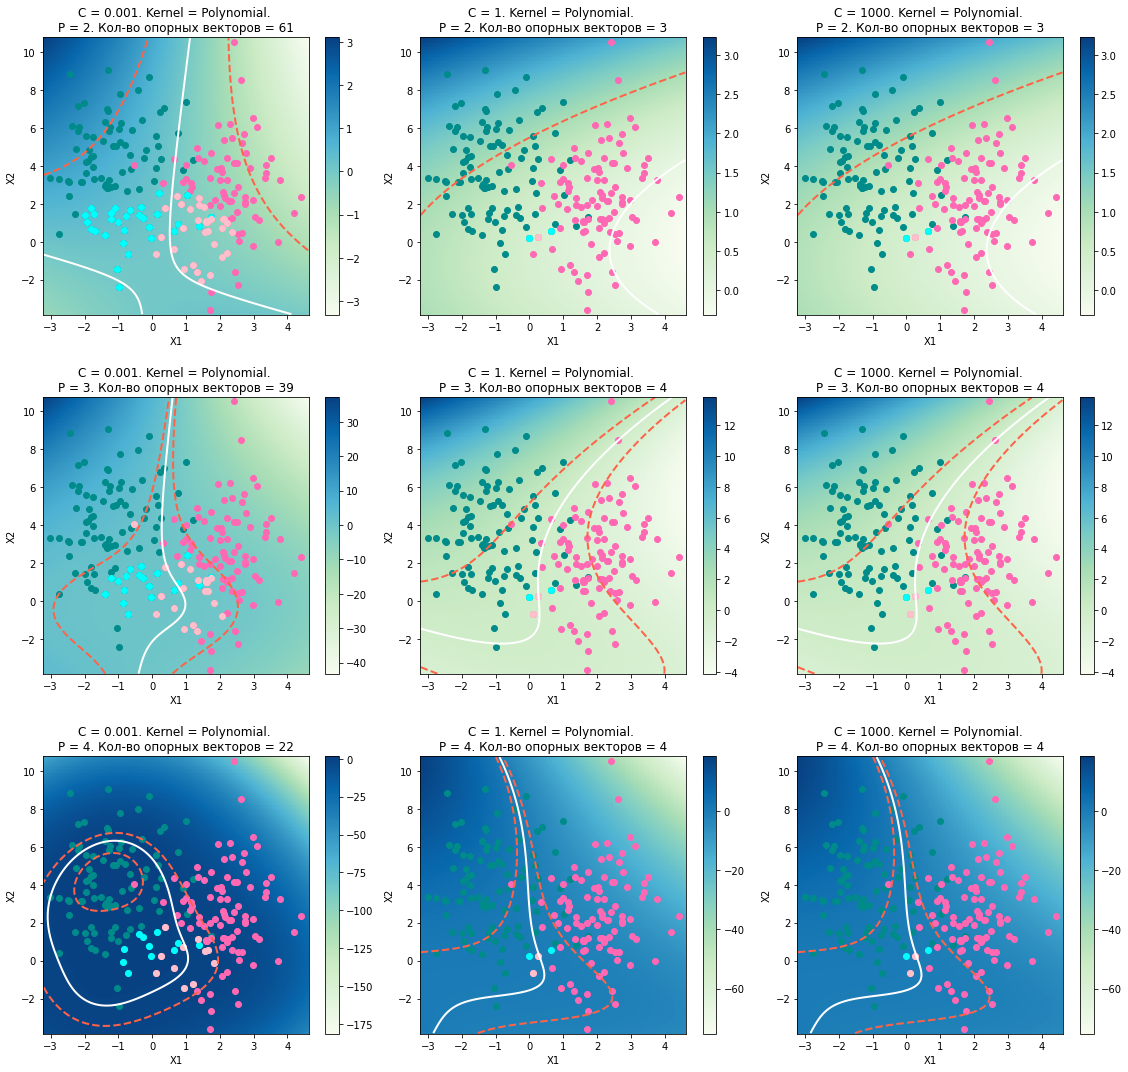

In [655]:
fig, ax = plt.subplots(3, 3, figsize=(16, 15))

kernel_type = "Polynomial"
C_array = [0.001, 1, 1000]
p_array = [2, 3, 4]


for i in range(3):
    for j in range(3):
        X = X_poor_sep
        y = y_poor_sep

        svm = KernelSVM(X, y, C=C_array[j], kernel_type=kernel_type, p=p_array[i])
        svm.fit()
        svm.plot_graph(ax[i][j], fig)

### Визуально по данным графикам я могу сделать вывод о том, что точность нашей модели для полиномов высокой степени выше. Большое значение C тоже помогает найти лучшее решение.

### 4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

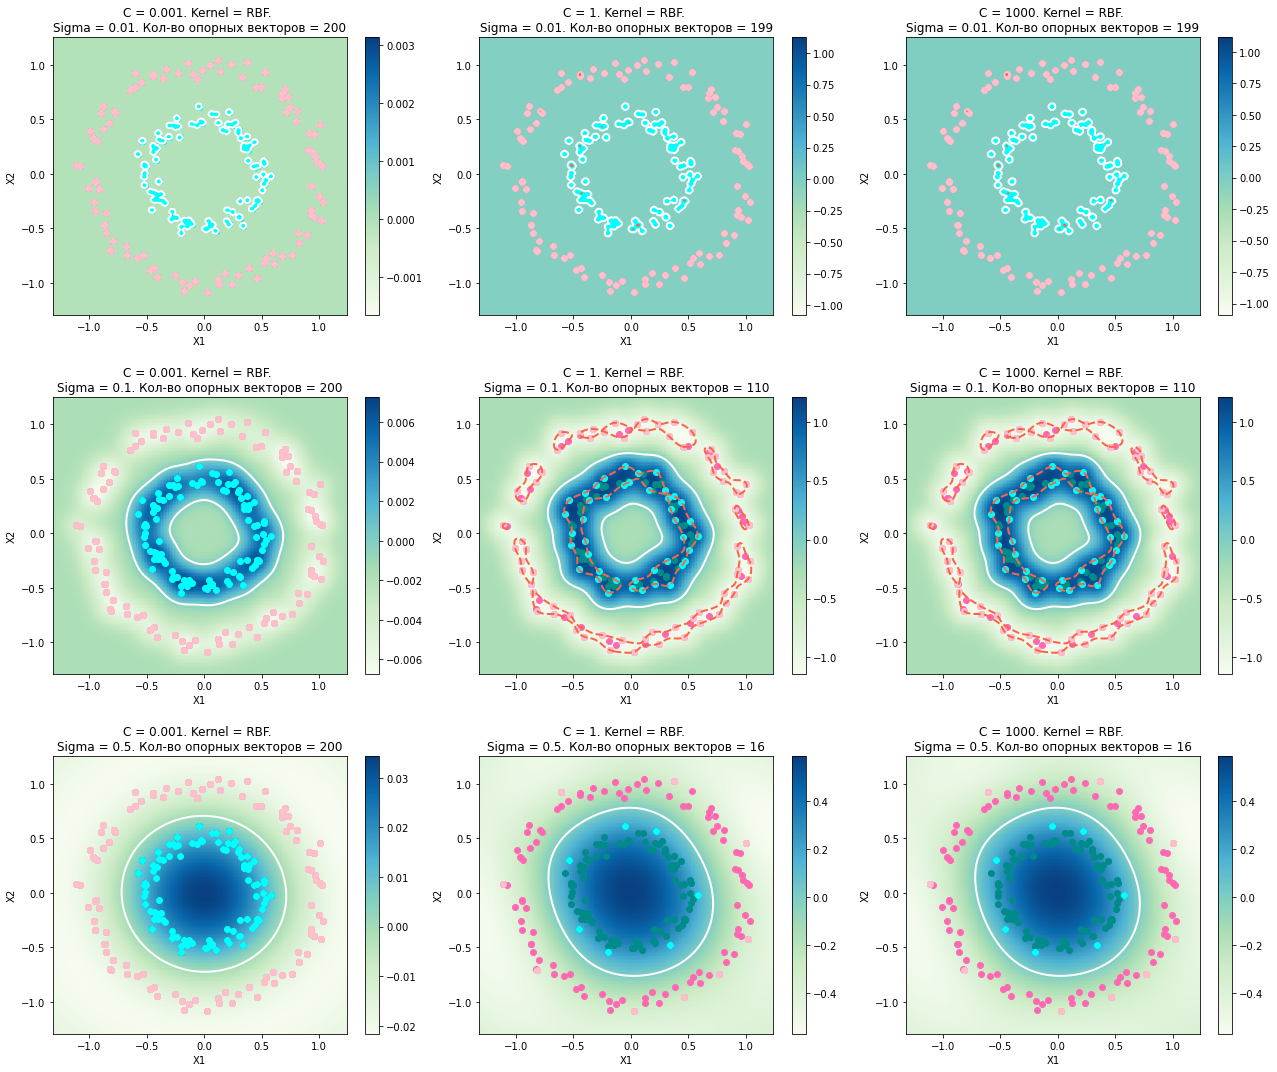

In [656]:
fig, ax = plt.subplots(3, 3, figsize=(18, 15))

kernel_type = "RBF"
C_array = [0.001, 1, 1000]
sigma_array = [0.01, 0.1, 0.5]


for i in range(3):
    for j in range(3):
        X = X_not_lin_sep
        y = y_not_lin_sep

        svm = KernelSVM(X, y, C=C_array[j], kernel_type=kernel_type, sigma=sigma_array[i])
        svm.fit()
        svm.plot_graph(ax[i][j], fig)

### По графикам видно, что малое значение sigma приводит к переобучению модели. Большое значение sigma описывает данные более обобщенно. Для данной выборки C не внесло большой роли при нахождении решения.

# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [520]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/annafilippova/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['size', 'f', 'matrix']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

/var/folders/dw/dyhkj4r524l176k2g7czk3x80000gn/T/ipykernel_13219/2390794766.py:16: UserWarning: linewidths is ignored by contourf
  contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')


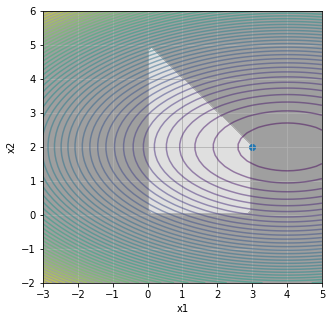

In [521]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [522]:
np.array([True, False, False]) & np.array([True, False, True])

array([ True, False, False])

In [523]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

array([ True, False, False])

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [524]:
!pip install --upgrade --user cvxopt

Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [525]:
from cvxopt import solvers
?solvers.qp

## Пример работы с cvxopt

In [526]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

[ 1.00e+00  3.00e+00  5.00e+00]
[ 2.00e+00  4.00e+00  6.00e+00]

(2, 3)


In [527]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
[-1.00e+00 -3.00e+00]
[ 2.00e+00  5.00e+00]
[ 3.00e+00  4.00e+00]
 (5, 2)


In [528]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

[ 7.13e-07]
[ 5.00e+00]

20.00000617311241


In [529]:
sol

{'x': <2x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <5x1 matrix, tc='d'>,
 'z': <5x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 8.788553731700882e-06,
 'relative gap': 4.394277440499181e-07,
 'primal objective': 20.00000617311241,
 'dual objective': 19.99999738455868,
 'primal infeasibility': 1.4066544268421197e-16,
 'dual infeasibility': 2.9763180929248306e-16,
 'primal slack': 7.131816408856409e-07,
 'dual slack': 1.5069511036047206e-08,
 'iterations': 8}

In [530]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]



Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [531]:
from sklearn.datasets import make_classification

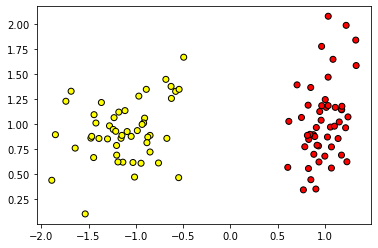

In [532]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

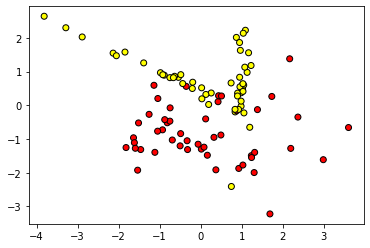

In [533]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

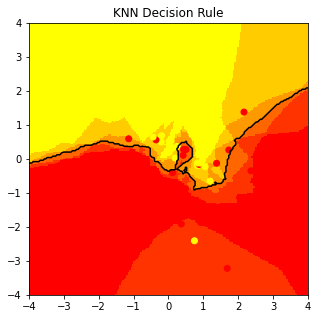

In [534]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [535]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))

In [536]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        pass
            
    def predict(self, X):
        pass